In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


data_set = 'kin 1h processed.dat'
data_set_name = data_set.split('.')[0]

dat = pd.read_csv('datasets/' + data_set, header = None, sep = '\t', skiprows = 1, decimal = ',')
wv = dat[1]
dat = dat.iloc[:,2:]

time = np.arange(len(dat.T))



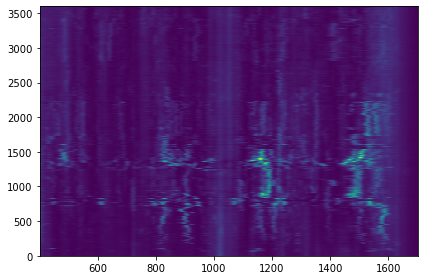

In [5]:
plt.pcolormesh(wv, time, dat.T, shading=  'auto')
plt.tight_layout()
plt.savefig(data_set_name + 'data.png', dpi = 300)
plt.show()

In [6]:
import sys
import logging


from pymcr.mcr import McrAR
from pymcr.regressors import NNLS

mcrar = McrAR(c_regr=NNLS(), st_regr=NNLS(), c_constraints=[], st_constraints=[])
logger = logging.getLogger('pymcr')
logger.setLevel(logging.DEBUG)
stdout_handler = logging.StreamHandler(stream=sys.stdout)
stdout_format = logging.Formatter('%(message)s')  # Just a basic message akin to print statements
stdout_handler.setFormatter(stdout_format)
logger.addHandler(stdout_handler)




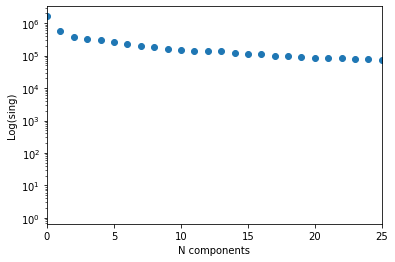

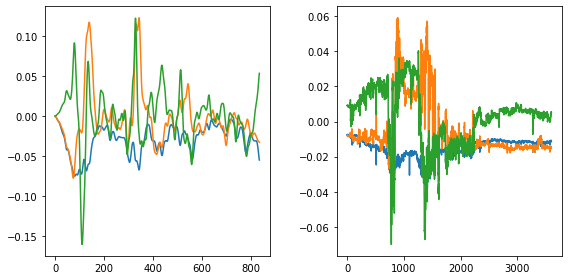

In [22]:
#creating guess from SVD
u, sing, a = np.linalg.svd(dat)

plt.plot(sing, 'o')
plt.yscale('log')
plt.ylabel('Log(sing)')
plt.xlabel('N components')
plt.xlim(0, 25)
plt.show()
fig, ax = plt.subplots(1, 2, figsize = (8, 4))

for i in range(3):
    ax[0].plot(u.T[i])
    ax[1].plot(a[i])
    
   # reconstructed += np.outer(u.T[i], a[i]) * sing[i]
plt.tight_layout()
plt.subplots_adjust(wspace = 0.3)
plt.show()

In [42]:
def start_MCR(N_comp, u_vectors, a_vectors):
    mcrar.tol_increase = 1
    mcrar.tol_n_increase = 80
    mcrar.tol_n_above_min = 80
    mcrar.max_iter = 1000
    mcrar.tol_err_change  = 1E-5
    
    guess_spectra = []
    
    for i in range(N_comp):
        u_guess = u.T[i]
        a_complement = a[i]
        
        if np.sum(u_guess) < 0:
            if np.sum(a_complement) < 0:
                u_guess = - u_guess # flipping when both u and v are mostly negative
                
        guess_spectra.append(u_guess)
            
        
    
    return mcrar.fit(dat.T, ST=guess_spectra)

start_MCR(11, u, a)

Change in err below tol_err_change (9.8861e-06). Exiting.
Change in err below tol_err_change (9.8861e-06). Exiting.
Change in err below tol_err_change (9.8861e-06). Exiting.
Change in err below tol_err_change (9.8861e-06). Exiting.


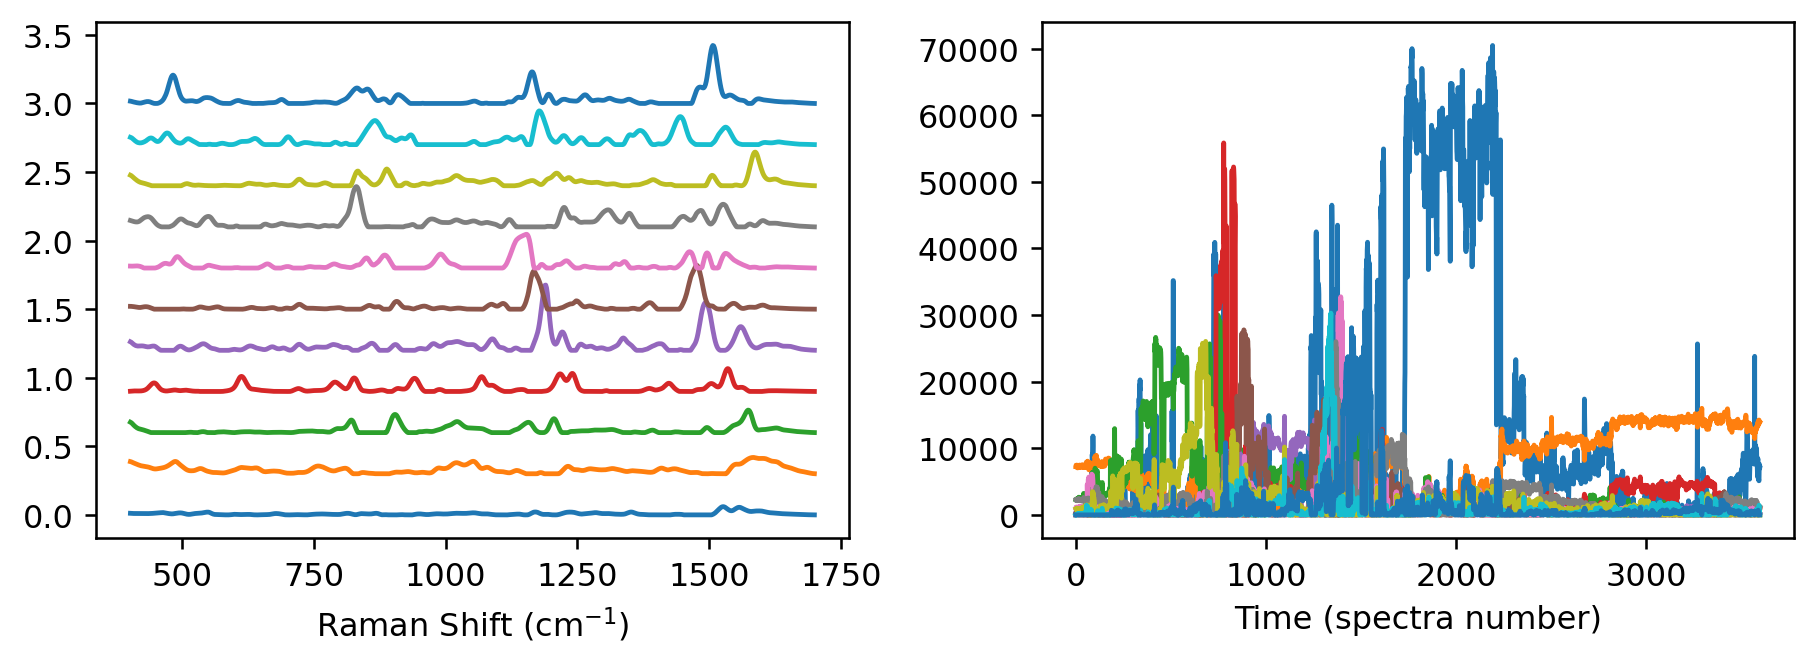

In [44]:
fig, ax = plt.subplots(1, 2, figsize = (8, 3), dpi = 230)
i = 0
for i, (spectrum, trace) in enumerate(zip(mcrar.ST_opt_, mcrar.C_opt_.T)):
    
    ax[0].plot(wv, spectrum + i*0.3)
    ax[1].plot(trace)
    ax[0].set_xlabel('Raman Shift (cm$^{-1}$)')
    ax[1].set_xlabel('Time (spectra number)')

plt.subplots_adjust(wspace = 0.3)   
plt.tight_layout()
plt.savefig(data_set_name + 'MCR_components.png')

plt.show()

fitted = np.dot( mcrar.C_opt_, mcrar.ST_opt_ ).T

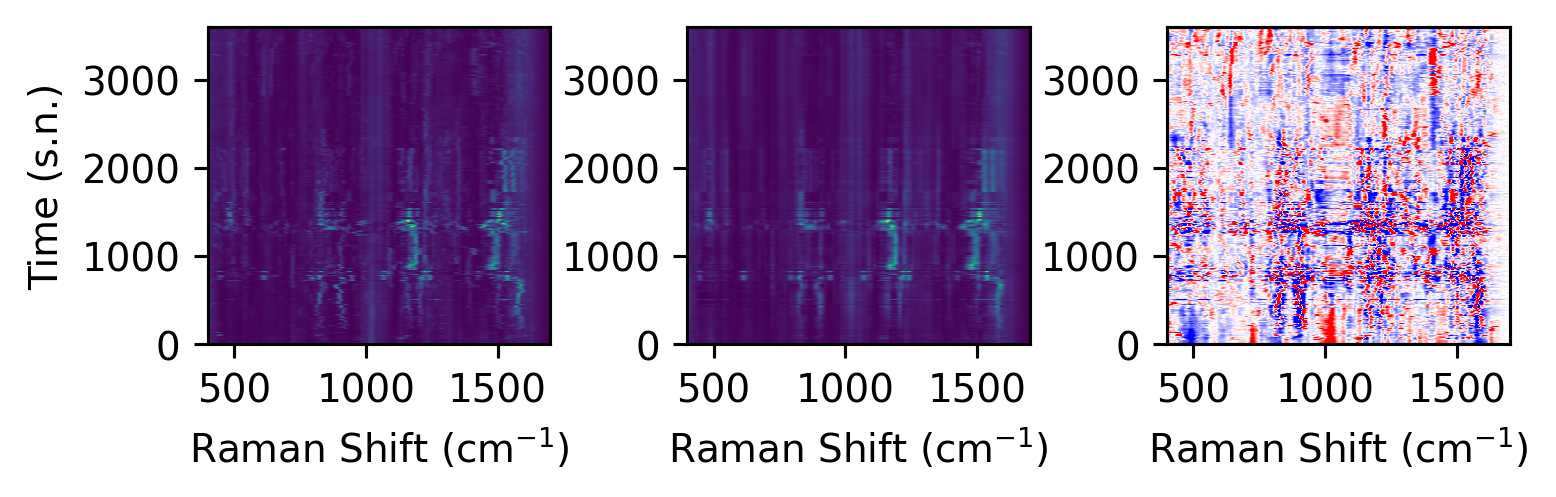

In [153]:
fig, axs = plt.subplots(1, 3, figsize = (6, 1.5), dpi = 280)
time = np.arange(len(dat.T))
res = dat.T - fitted.T
axs[0].pcolormesh(wv, time, dat.T, shading=  'auto')

axs[1].pcolormesh(wv, time, fitted.T, shading=  'auto')
axs[2].pcolormesh(wv, time, res, shading=  'auto', vmax = 500, vmin = -500, cmap = 'bwr')

axs[0].set_ylabel('Time (s.n.)')
for i in range(3):
    axs[i].set_xlabel('Raman Shift (cm$^{-1}$)')
plt.subplots_adjust(wspace = 0.4)

plt.savefig(data_set_name + 'Residuals.png', dpi = 300, transparent = False)
plt.show()

In [35]:
var = res**2
var = var.sum().sum()
var

322380778577.4393

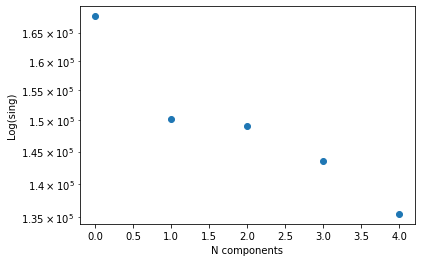

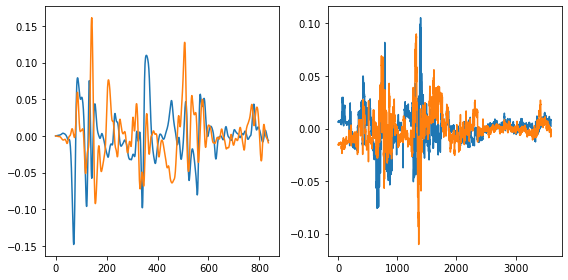

In [37]:
#Second SVD on the residuals of the fit
#reconstructed = np.zeros_like(dat)
u_res, sing_res, a_res = np.linalg.svd(dat - fitted)

plt.plot(sing_res[0:5], 'o')
plt.yscale('log')
plt.ylabel('Log(sing)')
plt.xlabel('N components')
plt.show()

fig, ax = plt.subplots(1, 2, figsize = (8, 4))

for i in range(2):
    ax[0].plot(u_res.T[i])
    ax[1].plot(a_res[i])
    
   # reconstructed += np.outer(u.T[i], a[i]) * sing[i]

plt.subplots_adjust(wspace = 0.3)
plt.tight_layout()
plt.savefig(data_set_name+ 'SVD_on_res.png', dpi = 300)
plt.show()

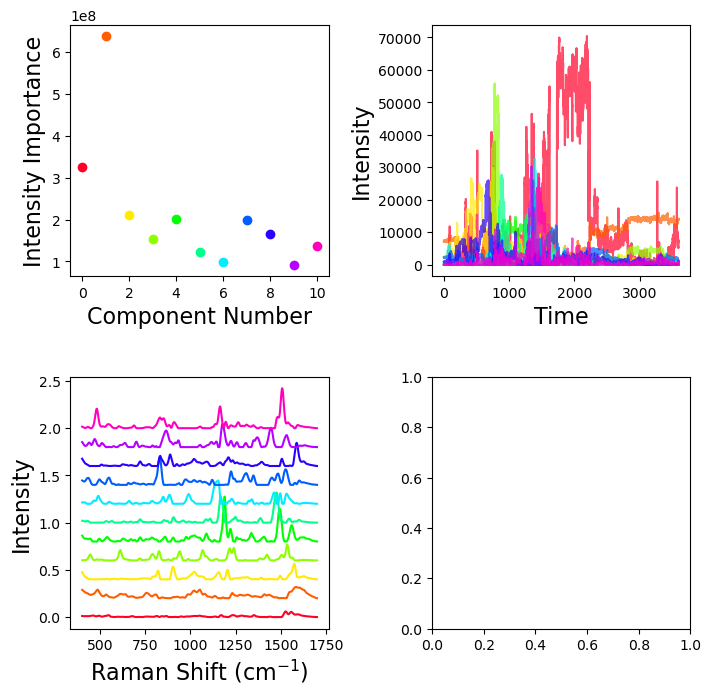

In [151]:
#addition, trying to rank the spectra components based on their correlation with the data
import matplotlib.cm as cm

cmap = cm.gist_rainbow(np.linspace(0, 1, 11))
fig, axs = plt.subplots(2, 2, figsize = (8,8 ), dpi = 100)

importance = mcrar.C_opt_.T.sum(axis = 1) * mcrar.ST_opt_.T.sum(axis=0)
for i, imp in enumerate(importance):
    axs[0,0].plot(i, imp, 'o', color = cmap[i])
axs[0,0].set_xlabel('Component Number', fontsize = 16)
axs[0,0].set_ylabel('Intensity Importance', fontsize = 16)

for i, trace in enumerate(mcrar.C_opt_.T):
    axs[0,1].plot(trace, alpha = 0.7, color = cmap[i])
axs[0,1].set_xlabel('Time', fontsize = 16)
axs[0,1].set_ylabel('Intensity', fontsize = 16)

for i, spectrum in enumerate(mcrar.ST_opt_):
    axs[1,0].plot(wv, spectrum + 0.2*i, color = cmap[i])
axs[1,0].set_xlabel('Raman Shift (cm$^{-1}$)', fontsize = 16)
axs[1,0].set_ylabel('Intensity', fontsize = 16)

plt.subplots_adjust(wspace= 0.4, hspace= 0.4)
plt.savefig('Importance.png', dpi = 300, transparent = False)
plt.show()


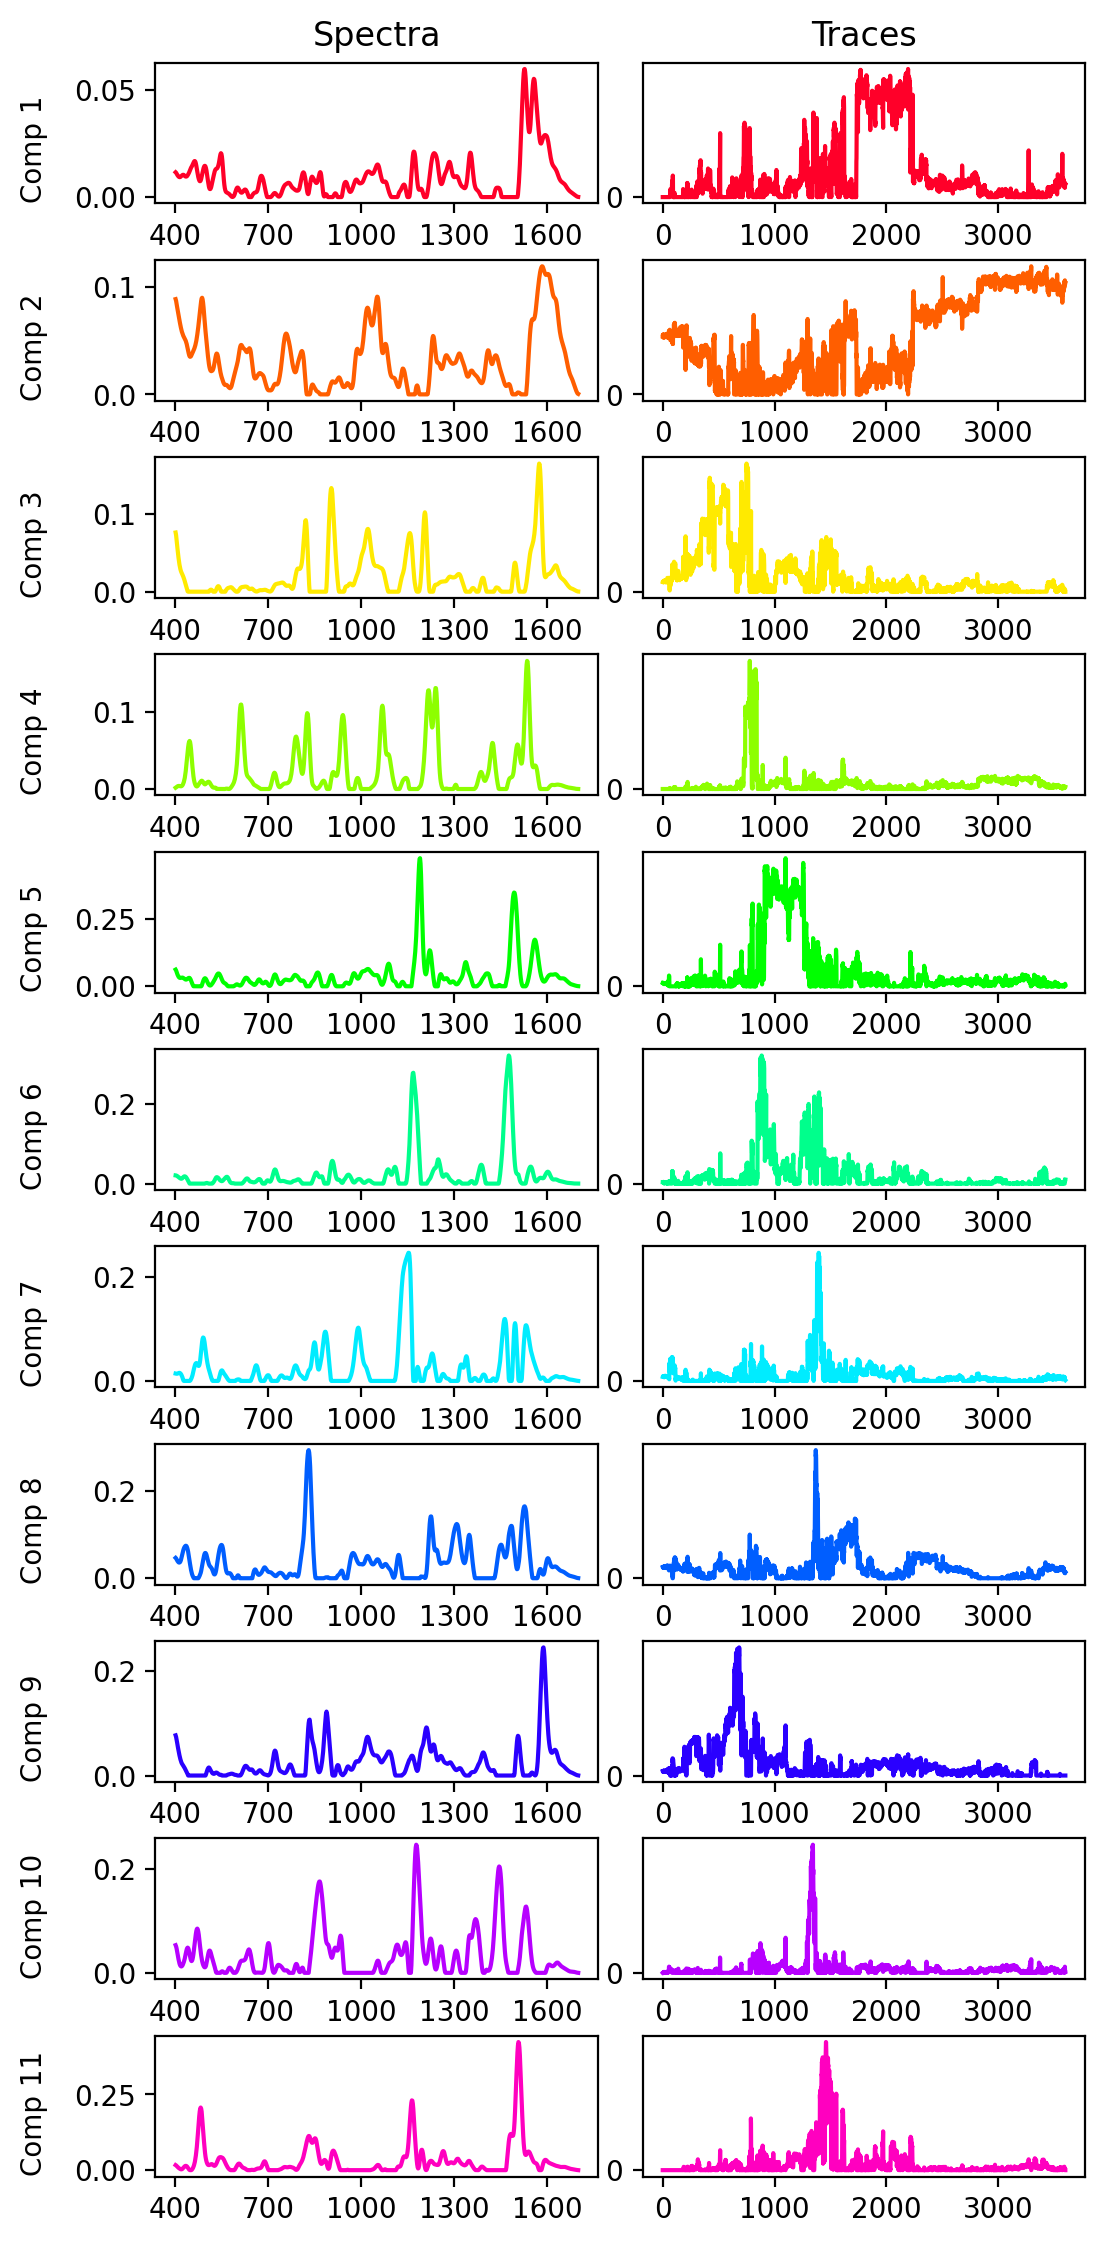

In [152]:
import matplotlib.cm as cm

cmap = cm.gist_rainbow(np.linspace(0, 1, 11))
fig, axs = plt.subplots(11, 2, figsize = (6,14 ), dpi = 200)

importance = mcrar.C_opt_.T.sum(axis = 1) * mcrar.ST_opt_.T.sum(axis=0)
for i, spectrum in enumerate(mcrar.ST_opt_):
    axs[i,0].plot(wv, spectrum, color = cmap[i])
    axs[i,0].set_xticks(np.arange(400, 1800, 300))
 #   axs[i,0].set_yticks([])
    axs[i,0].text(-100, 0, f'Comp {i + 1}', rotation = 90)
for i, trace in enumerate(mcrar.C_opt_.T):
    axs[i,1].plot(trace, alpha = 1., color = cmap[i])
 #   axs[i,1].set_xticks([])
    axs[i,1].set_yticks([0])


    
axs[0,0].set_title('Spectra')
axs[0,1].set_title('Traces')

plt.subplots_adjust(wspace= 0.1, hspace= 0.4)
plt.savefig('Components_11_MCR.png', dpi = 300, transparent = False)
plt.show()

 ...]

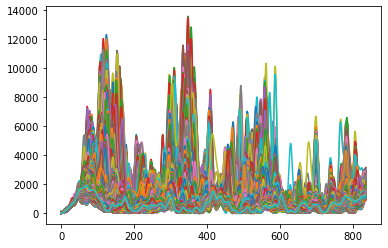

In [149]:
plt.plot(dat)